In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/MVA/graph_mlc/src


In [3]:
from util import *
from params import *
from imports import *

from data.dataset import *
from data.transforms import *

from model_zoo.common import *
from model_zoo.ssgrl import *

from training.train import *
from training.freezing import *

In [4]:
seed_everything(SEED)

# Datasets

In [5]:
trainval_dataset = MLCDataset(TRAINVAL_IMGS, 
                              transforms=get_transfos(size=IMG_SIZE),
                              img_path=IMG_PATH,
                              annotation_path=ANNOTATION_PATH
                             )

In [6]:
test_dataset = MLCDataset(TEST_IMGS, 
                          transforms=get_transfos(test=True, size=IMG_SIZE),
                          img_path=IMG_PATH,
                          annotation_path=ANNOTATION_PATH
                         )

# Loading GloVe Embeddings

In [7]:
os.listdir(GLOVE_PATH)

['glove.6B.300d.txt',
 'glove.6B.200d.txt',
 'glove.6B.50d.txt',
 'glove.6B.100d.txt']

In [8]:
embeddings_dict = {}
with open(GLOVE_PATH + f"glove.6B.{GLOVE_DIM}d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [9]:
embeddings_dict['diningtable'] = embeddings_dict['table']
embeddings_dict['pottedplant'] = embeddings_dict['plant']
embeddings_dict['tvmonitor'] = embeddings_dict['tv']

In [10]:
class_embeddings = np.zeros((NUM_CLASSES, GLOVE_DIM))

In [11]:
for c in range(len(CLASSES)):
    try:
        class_embeddings[c, :] = np.array(embeddings_dict[CLASSES[c]])
    except:
        print(f"No embedding found for {c}")

In [12]:
class_embeddings.shape

(20, 300)

# Building Coocurence Matrix

In [13]:
THRESHOLD = 0.1
P = 0.25

In [14]:
y = trainval_dataset.y.astype(int)

In [15]:
ocurences = np.repeat(np.sum(y, 0, keepdims=True), NUM_CLASSES, axis=0)
union = (ocurences + ocurences.T) / 2

In [16]:
coocurence = y.T @ y # / union

In [17]:
coocurence = (coocurence / y.sum(0)).T

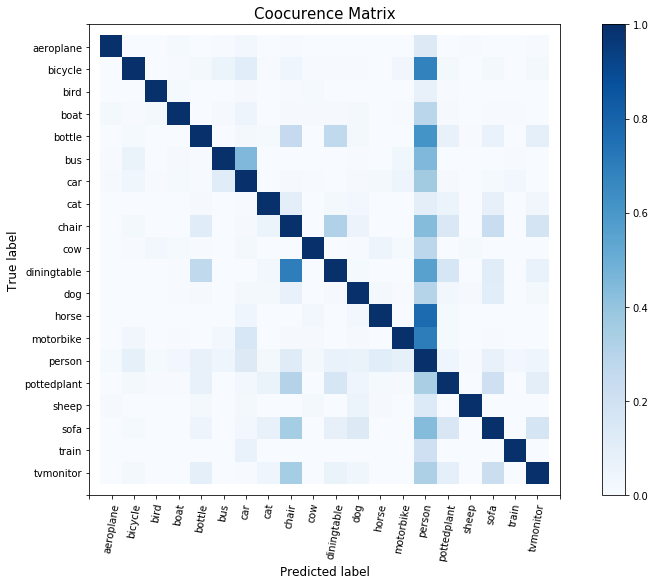

In [18]:
plot_coocurence(coocurence, CLASSES)

In [19]:
# coocurence = threshold_and_smooth_matrix(coocurence, t=THRESHOLD, p=P)
# plot_coocurence(coocurence, CLASSES)

# Model

In [20]:
def train_ssgrl(backbone, train_dataset, val_dataset, 
                coocurence, class_embeddings,
                test_dataset=None, use_si=True,
                cp=False, model_name='model', threshold=0.5):
    
    seed_everything(SEED)
    
    d = 1024 #if backbone == "resnet34" else 4096
    model = SSGRLClassifier(backbone, coocurence, class_embeddings, d1=d, d2=d, 
                            use_si=use_si, time_steps=3, logit_fts=d).cuda()

    print('\n- Training with frozen backbone : ')

    freeze(model)
    for layer in ['semantic_decoupling', 'semantic_intraction', 'logits', 'fo']:
        unfreeze_layer(model, layer)

    n_parameters = count_parameters(model)
    print(f'    -> {n_parameters} trainable parameters\n')

    fit(model, train_dataset, val_dataset, epochs=3, batch_size=32, warmup_prop=0, lr=1e-3, min_lr=1e-4,
        verbose=1, verbose_eval=1, cp=False, model_name='model')

    print('\n- Training : ')

    if backbone == 'resnet34':
        unfreeze(model)
    else:
        unfreeze_layer(model, 'layer4')
#         unfreeze(model)
        
    n_parameters = count_parameters(model)
    print(f'    -> {n_parameters} trainable parameters\n')

    fit(model, train_dataset, val_dataset, epochs=5, batch_size=8, warmup_prop=0, lr=1e-4, min_lr=1e-6,
        verbose=1, verbose_eval=1, cp=cp, model_name=model_name)

    print('\n- Evaluating: \n')

    if cp:
        load_model_weights(model, model_name, verbose=1)
        
    pred_val = predict_voc(model, val_dataset)
    print(f' - Scored {voc12_mAP(pred_val) :.3f} on validation data')
    aps = voc12_mAP(pred_val, return_aps=True)
    
    if test_dataset is not None:
        pred_test = predict_voc(model, test_dataset)
        print(f' - Scored {voc12_mAP(pred_test) :.3f} on test data\n')
    
    return model, aps

In [21]:
# backbone = 'resnet34'
# backbone = 'resnet101'
# backbone = 'resnext101'

In [22]:
backbone = 'resnet34'
model, aps = train_ssgrl(backbone, trainval_dataset, test_dataset, coocurence, class_embeddings, 
                    model_name=backbone, use_si=True)


- Training with frozen backbone : 
    -> 2952213 trainable parameters

Epoch 1/3 	 lr=1.0e-03 	 t=77s 	 loss=0.139 	 mAP=0.882 	 val_loss=0.072 	 
Epoch 2/3 	 lr=5.5e-04 	 t=77s 	 loss=0.071 	 mAP=0.904 	 val_loss=0.060 	 
Epoch 3/3 	 lr=1.0e-04 	 t=77s 	 loss=0.059 	 mAP=0.911 	 val_loss=0.057 	 

- Training : 
    -> 26596181 trainable parameters

Epoch 1/5 	 lr=1.0e-04 	 t=134s 	 loss=0.094 	 mAP=0.867 	 val_loss=0.077 	 
Epoch 2/5 	 lr=8.6e-05 	 t=133s 	 loss=0.072 	 mAP=0.880 	 val_loss=0.072 	 
Epoch 3/5 	 lr=5.1e-05 	 t=133s 	 loss=0.052 	 mAP=0.904 	 val_loss=0.060 	 
Epoch 4/5 	 lr=1.5e-05 	 t=133s 	 loss=0.036 	 mAP=0.915 	 val_loss=0.054 	 
Epoch 5/5 	 lr=1.0e-06 	 t=133s 	 loss=0.029 	 mAP=0.915 	 val_loss=0.054 	 

- Evaluating: 

 - Scored 0.915 on validation data


In [26]:
np.save('../output/aps_ssgrl_resnet34_576.npy', np.array(aps))

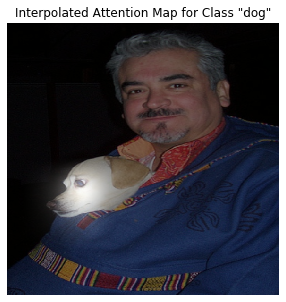

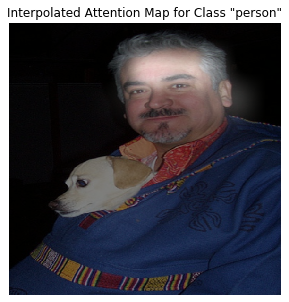

In [23]:
plot_attention_ssgrl(model, test_dataset, 0)